# Real Estate Market Selection Model

<b> Goal of Model and Analysis </b>
    
The goal of this analysis is to help inform which city Mehrmah and I decide to buy an investment property in.  The output of the analysis will be a ranked list of cities with forecasted 5YR and 10YR appreciation values.

In order to reduce the risk of us losing money, a strict criteria for our next investment property is that it will be cashflow neutral or better, however we recognize that appreciation will likely be the primary way to get strong returns.  Therefore, our objective function is to maximize appreciation under the constraint that the property cashflows with a 20% downpayment. 

Given a property’s ability to cashflow requires analysis on the individual property, we will first do the analysis to determine which markets to look at individual properties in.  


In [1]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.lyft.net/simple/, https://pypi.lyft.net/pypi/
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandasql

Looking in indexes: https://pypi.lyft.net/simple/, https://pypi.lyft.net/pypi/
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import pandasql

# Data Imports and Reformating

In [4]:
# import zipcode to FIPS mapping
zip_mapping = pd.read_csv('ZIP-COUNTY-FIPS_2018-03.csv')
zip_mapping.rename(columns={"ZIP": "zipcode", "STCOUNTYFP": "fips", "CITY": "city_mapped", "STATE": "state_mapped", "COUNTYNAME":"county_mapped", "CLASSFP":"classfp"}, inplace = True)

In [5]:
# import 2010 population by zipcode data for ZHVI weighting
pop_weights = pd.read_csv('Population/Census+Population+By+Zipcode+(ZCTA).csv')

In [6]:
# import and reformat ZHVI data
zhvi = pd.read_csv('ZHVI/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
zhvi = pd.melt(zhvi, id_vars=['RegionID','SizeRank','RegionName','RegionType','StateName','State','City','Metro','CountyName'])
zhvi.rename(columns={"RegionName": "zipcode", "StateName": "state", "Metro": "msa", "CountyName": "county", "variable":"month", "value":"zhvi"}, inplace = True)
zhvi['month'] = pd.to_datetime(zhvi.month, infer_datetime_format=True)
zhvi['year'] = zhvi.month.dt.year
zhvi = zhvi[["zipcode","state","msa","county","year","zhvi"]].loc[zhvi.month.dt.month == 1]
zhvi = zhvi.merge(zip_mapping, how = 'left',left_on = 'zipcode',right_on = 'zipcode')


In [7]:
# import and reformat GDP data
gdp_county = pd.read_csv('GDP/CAGDP2__ALL_AREAS_2001_2019.csv', skipfooter = 4)
gdp_county.GeoFIPS = gdp_county.GeoFIPS.str.replace('"', '')
gdp_county = pd.melt(gdp_county, id_vars=['GeoFIPS','GeoName','Region','TableName','LineCode','IndustryClassification','Description','Unit'])
gdp_county.rename(columns={"GeoFIPS": "fips", "GeoName": "county", "Description": "metric", "variable": "year", "value":"gdp"}, inplace = True)
gdp_county = gdp_county[["fips","county","metric","year","gdp"]]
gdp_county = gdp_county[gdp_county.gdp.str.isnumeric() == True]  #dropping empty values
gdp_county.gdp = pd.to_numeric(gdp_county.gdp)
gdp_county = gdp_county.pivot_table(index=["fips","county","year"], columns="metric")['gdp'].reset_index()
gdp_county.columns.name = None
gdp_county.fips = gdp_county.fips.str.replace(' ','')
gdp_county.fips = pd.to_numeric(gdp_county.fips)
gdp_county.year = gdp_county.year.astype(int)


/code/venvs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [8]:
# import and reformat 2000 Population data
pop_2000 = pd.read_csv('Population/DECENNIALSF12000.P001_data_with_overlays_2021-07-23T112021.csv')

#all FIPS start with 0500000US in this dataset.  cutting that part out
pop_2000.GEO_ID = pop_2000.GEO_ID.str.replace('0500000US','')
pop_2000 = pop_2000[~(pop_2000.GEO_ID == 'id')] #filtering out header row
pop_2000.GEO_ID = pd.to_numeric(pop_2000.GEO_ID)
pop_2000["year"] = 2000
pop_2000.rename(columns={"GEO_ID": "fips", "NAME": "county", "P001001": "population"}, inplace = True)


In [9]:
# import and reformat 2010 to 2020 Population data
pop_2010_2020 = pd.read_csv('Population/PEPPOP2019.PEPANNRES_data_with_overlays_2021-08-08T193054.csv')
pop_2010_2020.head()
pop_2010_2020 = pop_2010_2020[~pop_2010_2020.DATE_CODE.str.contains('Census')]
pop_2010_2020 = pop_2010_2020[~pop_2010_2020.DATE_CODE.str.contains('base')]
pop_2010_2020.DATE_CODE = pop_2010_2020.DATE_CODE.str.slice(stop = 8)
pop_2010_2020.DATE_CODE = pop_2010_2020.DATE_CODE.str.slice(start = 4)
pop_2010_2020 = pop_2010_2020[~(pop_2010_2020.GEO_ID == 'id')] #filtering out header row
pop_2010_2020.GEO_ID = pop_2010_2020.GEO_ID.str.replace('0500000US','')
pop_2010_2020.rename(columns={"GEO_ID": "fips", "NAME": "county","DATE_CODE": "year", "POP": "population"}, inplace = True)
pop_2010_2020.fips = pd.to_numeric(pop_2010_2020.fips)
pop_2010_2020.year = pd.to_numeric(pop_2010_2020.year)
pop_2010_2020.population = pd.to_numeric(pop_2010_2020.population)


In [10]:
#merge the two population datasets together
population = pd.concat([pop_2000, pop_2010_2020])

#linearly interpolate missing years from 2000 to 2010
population_start = population[population.year ==2000][['fips','population']]
population_start.rename(columns={"population":"2000_pop"}, inplace = True)

population_end = population[population.year ==2010][['fips','population']]
population_end.rename(columns={"population":"2010_pop"}, inplace = True)

population_slope = population_start.merge(population_end, how = 'left', on = 'fips')
population_slope["slope"] = (pd.to_numeric(population_slope["2010_pop"]) - pd.to_numeric(population_slope["2000_pop"]))/10
population_slope

fips = pd.DataFrame(population.fips.unique(), columns = ['fips'])
years = pd.DataFrame({'year': [x for x in range(2001, 2010)]})

fips['key'] = 1
years['key'] = 1

interpolated_pop = pd.merge(fips, years, on ='key').drop("key", 1)
interpolated_pop = interpolated_pop.merge(population_slope, how = 'left', on = 'fips')
interpolated_pop["baseline_year"] = 2000
interpolated_pop["2000_pop"] = pd.to_numeric(interpolated_pop["2000_pop"])
interpolated_pop["2010_pop"]= pd.to_numeric(interpolated_pop["2010_pop"])
interpolated_pop["population"] = interpolated_pop["2000_pop"] + (interpolated_pop["year"]-interpolated_pop["baseline_year"])*interpolated_pop["slope"]

#15 missing fips due to 2000 population data not existing
print(interpolated_pop[interpolated_pop.population.isnull()].fips.nunique())
interpolated_pop = interpolated_pop[["fips","year","population"]]

population_w_estimates = pd.concat([population[["fips","year","population"]], interpolated_pop]) 

#df['key'] = 1
#df1['key'] = 1
#result = pd.merge(df, df1, on ='key').drop("key", 1)

15


In [11]:
# import rent data


rent = pd.read_csv("Zip_ZORI_AllHomesPlusMultifamily_SSA.csv")
rent

,RegionID,RegionName,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,...,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06
0,61639,10025,1,"New York, NY",2889.0,2904.0,2919.0,2935.0,2949.0,2964.0,...,2986.0,2958.0,2939.0,2919.0,2900.0,2883.0,2865.0,2848.0,2834.0,2820.0
1,84654,60657,2,"Chicago, IL",1444.0,1449.0,1454.0,1460.0,1465.0,1470.0,...,1645.0,1642.0,1639.0,1636.0,1634.0,1631.0,1629.0,1627.0,1625.0,1623.0
2,61637,10023,3,"New York, NY",3014.0,3024.0,3033.0,3043.0,3052.0,3061.0,...,2997.0,2968.0,2946.0,2924.0,2902.0,2881.0,2861.0,2841.0,2824.0,2807.0
3,91982,77494,4,"Houston, TX",1454.0,1451.0,1448.0,1445.0,1442.0,1439.0,...,1439.0,1443.0,1449.0,1456.0,1462.0,1469.0,1476.0,1483.0,1490.0,1497.0
4,84616,60614,5,"Chicago, IL",1685.0,1690.0,1695.0,1700.0,1705.0,1709.0,...,1924.0,1918.0,1915.0,1912.0,1909.0,1906.0,1904.0,1902.0,1900.0,1899.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1738,67751,23507,8041,"Virginia Beach, VA",1077.0,1075.0,NaN,1070.0,1068.0,1065.0,...,1182.0,1185.0,1188.0,1190.0,1193.0,1195.0,1198.0,1200.0,1203.0,1205.0
1739,84608,60606,8497,"Chicago, IL",1980.0,1979.0,1978.0,1977.0,1977.0,1977.0,...,2040.0,2023.0,2013.0,2003.0,1993.0,1984.0,1975.0,1966.0,1959.0,1952.0
1740,61620,10006,8506,"New York, NY",2982.0,2997.0,3013.0,3029.0,3045.0,3061.0,...,2968.0,2923.0,2887.0,2850.0,2814.0,2781.0,2747.0,2714.0,2685.0,2656.0
1741,58623,2109,8792,"Boston, MA",NaN,2778.0,NaN,2792.0,2799.0,2805.0,...,2900.0,2879.0,2865.0,2851.0,2837.0,2825.0,2813.0,2802.0,2792.0,2783.0


# Preparing ZHVI Data and Aggregating to the FIPS Level

In [12]:
zhvi = zhvi.merge(pop_weights, how = 'left',left_on = 'zipcode',right_on = 'Zip Code ZCTA')
zhvi['zhvi_pop_prod'] = zhvi['Census Population 2010']*zhvi['zhvi']

In [13]:
#Filter to dates with well populated ZHVI data and GDP data
zhvi = zhvi[zhvi.year > 2000]
zhvi = zhvi[zhvi.year < 2020]
zhvi['missing'] = zhvi.zhvi.isnull()
print(zhvi[zhvi.missing == True]['Census Population 2010'].sum()/zhvi['Census Population 2010'].sum())

#make a list of zipcodes with partial data to exclude from the analysis
zipmissing = zhvi.groupby('zipcode', as_index = False).missing.mean()
print(zipmissing[zipmissing.missing > 0].shape[0] / zipmissing.shape[0])
zipmissing = zipmissing[zipmissing.missing>0].zipcode
zhvi = zhvi[~zhvi.zipcode.isin(zipmissing)]

0.05319918337346067
0.39723717491406707


In [14]:
#Aggregate ZHVI from the zipcode level up to the FIPS level, weighting by 2010 population
zhvi_fips_agg = zhvi.groupby(['fips','year'], as_index = False).agg({'zhvi': 'mean','zhvi_pop_prod': 'sum', 'Census Population 2010': 'sum'})
zhvi_fips_agg['zhvi_weighted'] = zhvi_fips_agg['zhvi_pop_prod'] / zhvi_fips_agg['Census Population 2010']
zhvi_fips_agg.fips = zhvi_fips_agg.fips.astype(int)


In [15]:
# population and therefore weighted ZHVI is missing for 1 FIPS -filter to only data that mapped to 2010 population data
print(zhvi_fips_agg[zhvi_fips_agg.zhvi_weighted.isnull()].fips.nunique())
zhvi_fips_agg.zhvi_weighted.isnull().sum()/zhvi_fips_agg.shape[0]
zhvi_fips_agg = zhvi_fips_agg[zhvi_fips_agg.zhvi_weighted.isnull()==False]

1


# Joining ZHVI Data to Other Data Sources

In [16]:
# Merge ZHVI data with GDP data.  2% of FIPS don't have matching GDP data, filter those out
df_agg = zhvi_fips_agg.merge(gdp_county, how = 'left', on = ['fips','year'])
print(df_agg["All industry total"].isnull().sum()/df_agg.shape[0])
df_agg = df_agg[df_agg["All industry total"].isnull()==False]

0.02125124131082423


In [17]:
# Merge ZHVI data with population data
df_agg = df_agg.merge(population_w_estimates, how = 'left', on = ['fips','year'])
print(df_agg["population"].isnull().sum()/df_agg.shape[0])
df_agg = df_agg[~df_agg["population"].isnull()]

0.00020292207792207794


In [18]:
df_agg.head()

,fips,year,zhvi,zhvi_pop_prod,Census Population 2010,zhvi_weighted,county,Accommodation and food services,Administrative and support and waste management and remediation services,"Arts, entertainment, and recreation",...,Private industries,All industry total,Government and government enterprises,Manufacturing and information,Natural resources and mining,Private goods-producing industries 2/,Private services-providing industries 3/,Trade,Transportation and utilities,population
0,1001,2001,125288.666667,1.145516e+10,108787.0,105298.942429,"Autauga, AL",32162.0,NaN,1662.0,...,652410.0,748918.0,96507.0,195774.0,16213.0,276566.0,375844.0,94895.0,32302.0,44781.2
1,1001,2002,127334.833333,1.162606e+10,108787.0,106869.923686,"Autauga, AL",32655.0,NaN,1536.0,...,671240.0,781937.0,110698.0,196590.0,11951.0,245163.0,426077.0,102459.0,55406.0,45891.4
2,1001,2003,129304.250000,1.196953e+10,108787.0,110027.238972,"Autauga, AL",35535.0,NaN,1511.0,...,682843.0,804299.0,121456.0,165736.0,28183.0,227255.0,455589.0,112787.0,61079.0,47001.6
3,1001,2004,132550.166667,1.228776e+10,108787.0,112952.424159,"Autauga, AL",36899.0,NaN,1580.0,...,808170.0,946964.0,138793.0,204527.0,41858.0,283720.0,524450.0,119589.0,95693.0,48111.8
4,1001,2005,141508.166667,1.296247e+10,108787.0,119154.617252,"Autauga, AL",35707.0,NaN,1947.0,...,825221.0,969849.0,144628.0,219287.0,43221.0,296290.0,528930.0,126576.0,83560.0,49222


# Preparing data for export

In [19]:
# make a function to prepare the target feature desired (ie appreciation)
def target_prep(timeseries_df, start_year, lookforward, target_variable):
    baseline_df = timeseries_df[timeseries_df.year == start_year]
    lookforward_df = timeseries_df[timeseries_df.year == start_year + lookforward]
    df_out = baseline_df[["fips", target_variable]]
    df_out = df_out.merge(lookforward_df[['fips',target_variable]], how = 'left', on = 'fips')
    df_out[target_variable] = df_out.iloc[:, [2]].values/df_out.iloc[:, [1]].values
    df_out = df_out[["fips", target_variable]]
    df_out.columns = ['fips', target_variable + '_growth']
    return df_out

In [20]:
#function to calculate growth rate features over X year lookback

def growth_feature_prep(timeseries_df, start_year, look_back, cols_to_adj):
    baseline_df = timeseries_df[timeseries_df.year == start_year]
    lookback_df = timeseries_df[timeseries_df.year == start_year - look_back]

    df_out = baseline_df[["fips"]]
    
    for col in cols_to_adj:
        temp = baseline_df[['fips',col]]
        temp = temp.merge(lookback_df[['fips',col]], how = 'left', on = 'fips')
        temp[col] = temp.iloc[:, [1]].values/temp.iloc[:, [2]].values
        temp = temp[['fips',col]]
        temp.columns = ['fips', col + '_growth']
        df_out = df_out.merge(temp, how = 'left', on= 'fips')        
    return df_out


In [21]:
cols_to_adj = [#'   Accommodation and food services',
               #'   Administrative and support and waste management and remediation services',
               #'   Arts, entertainment, and recreation',
               #'   Durable goods manufacturing', 
               #'   Educational services',
               #'   Finance and insurance', 
               #'   Health care and social assistance',
               #'   Management of companies and enterprises',
               #'   Nondurable goods manufacturing',
               #'   Professional, scientific, and technical services',
               #'   Real estate and rental and leasing',
               #'  Agriculture, forestry, fishing and hunting',
               #'  Arts, entertainment, recreation, accommodation, and food services',
               '  Construction',
               #'  Educational services, health care, and social assistance',
               '  Finance, insurance, real estate, rental, and leasing',
               #'  Information', 
               '  Manufacturing',
               '  Mining, quarrying, and oil and gas extraction',
               #'  Other services (except government and government enterprises)',
               #'  Professional and business services', 
               '  Retail trade',
               #'  Transportation and warehousing', 
               #'  Utilities', 
               #'  Wholesale trade',
               ' Private industries', 
               'All industry total',
               'Government and government enterprises',
               #'Manufacturing and information', 
               #'Natural resources and mining',
               #'Private goods-producing industries 2/',
               #'Private services-providing industries 3/', 
               #'Trade',
               #'Transportation and utilities',
               'population'
]

In [22]:
fips_map = gdp_county.groupby(['fips','county'], as_index = False).year.count()
fips_map = fips_map[['fips','county']]

In [23]:
df_agg.columns

Index(['fips', 'year', 'zhvi', 'zhvi_pop_prod', 'Census Population 2010',
       'zhvi_weighted', 'county', '   Accommodation and food services',
       '   Administrative and support and waste management and remediation services',
       '   Arts, entertainment, and recreation',
       '   Durable goods manufacturing', '   Educational services',
       '   Finance and insurance', '   Health care and social assistance',
       '   Management of companies and enterprises',
       '   Nondurable goods manufacturing',
       '   Professional, scientific, and technical services',
       '   Real estate and rental and leasing',
       '  Agriculture, forestry, fishing and hunting',
       '  Arts, entertainment, recreation, accommodation, and food services',
       '  Construction',
       '  Educational services, health care, and social assistance',
       '  Finance, insurance, real estate, rental, and leasing',
       '  Information', '  Manufacturing',
       '  Mining, quarrying, and o

In [24]:
baseline_features = ['fips'
                    ,'Census Population 2010',
                     'zhvi_weighted',
                    #'   Accommodation and food services',
                    #'   Administrative and support and waste management and remediation services',
                    #'   Arts, entertainment, and recreation',
                    #'   Durable goods manufacturing', 
                    #'   Educational services',
                    #'   Finance and insurance', 
                    #'   Health care and social assistance',
                    #'   Management of companies and enterprises',
                    #'   Nondurable goods manufacturing',
                    #'   Professional, scientific, and technical services',
                    #'   Real estate and rental and leasing',
                    #'  Agriculture, forestry, fishing and hunting',
                    #'  Arts, entertainment, recreation, accommodation, and food services',
                    #'  Construction',
                    #'  Educational services, health care, and social assistance',
                    #'  Finance, insurance, real estate, rental, and leasing',
                    #'  Information', 
                    #'  Manufacturing',
                    #'  Mining, quarrying, and oil and gas extraction',
                    #'  Other services (except government and government enterprises)',
                    #'  Professional and business services', 
                    #'  Retail trade',
                    #'  Transportation and warehousing', 
                    #'  Utilities', 
                    #'  Wholesale trade',
                    ' Private industries', 
                    'All industry total',
                    'Government and government enterprises',
                    #'Manufacturing and information', 
                    #'Natural resources and mining',
                    #'Private goods-producing industries 2/',
                    #'Private services-providing industries 3/', 
                    #'Trade',
                     #'Transportation and utilities',
                     'population']

In [25]:
start_year = 2004
lookforward = 3
look_back = 3


df_target = target_prep(df_agg, start_year = start_year, lookforward = lookforward, target_variable = 'zhvi_weighted')
df_growth_features = growth_feature_prep(df_agg, start_year = start_year, look_back = look_back, cols_to_adj = cols_to_adj)
baseline_df = df_agg[df_agg.year == start_year]
df = df_target.merge(df_growth_features, how = 'left', on = 'fips')
df = df.merge(fips_map, how = 'left',on = 'fips')
df = df.merge(baseline_df[baseline_features], how = 'left',on = 'fips')

df_train_test = df

df_train_test.to_csv('df_train_test.csv', index = False)

/code/venvs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/code/venvs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [26]:
start_year = 2016
lookforward = 3
look_back = 3


df_target = target_prep(df_agg, start_year = start_year, lookforward = lookforward, target_variable = 'zhvi_weighted')
df_growth_features = growth_feature_prep(df_agg, start_year = start_year, look_back = look_back, cols_to_adj = cols_to_adj)
baseline_df = df_agg[df_agg.year == start_year]
df = df_target.merge(df_growth_features, how = 'left', on = 'fips')
df = df.merge(fips_map, how = 'left',on = 'fips')
df = df.merge(baseline_df[baseline_features], how = 'left',on = 'fips')

df_val = df

df_val.to_csv('df_validation.csv', index = False)

/code/venvs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/code/venvs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [27]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df.head(50)

,column_name,percent_missing
fips,fips,0.000000
All industry total,All industry total,0.000000
Private industries,Private industries,0.000000
zhvi_weighted,zhvi_weighted,0.000000
Census Population 2010,Census Population 2010,0.000000
county,county,0.000000
population_growth,population_growth,0.000000
Government and government enterprises_growth,Government and government enterprises_growth,0.000000
All industry total_growth,All industry total_growth,0.000000
Private industries_growth,Private industries_growth,0.000000


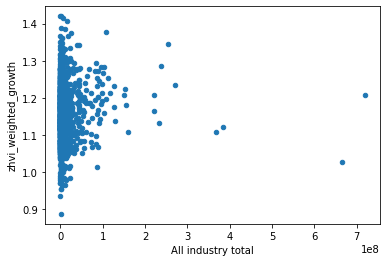

In [28]:
ax1 = df.plot.scatter(x='All industry total',
                      y='zhvi_weighted_growth')
                     #s='Census Population 2010')

<AxesSubplot:xlabel='All industry total_growth', ylabel='zhvi_weighted_growth'>

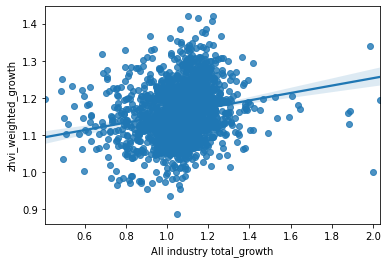

In [29]:
import seaborn as sns

df_trunc = df[(df["All industry total_growth"] > 0.1)&(df["All industry total_growth"] < 3)&(df["zhvi_weighted_growth"] > 0.1)&(df["zhvi_weighted_growth"] < 3)]

sns.regplot(x=df_trunc["All industry total_growth"], y=df_trunc["zhvi_weighted_growth"])


In [30]:
df.shape

(2075, 18)

In [31]:
val_df = 

SyntaxError: invalid syntax (<ipython-input-31-6a268ef8a15a>, line 1)